# MCT4001 Scientific Computing in Python Session 10
![mct-banner](https://raw.githubusercontent.com/wiki/MCT-master/Guides/assets/img/mct-banner.jpg)

In [1]:
# importing packages

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import sounddevice as sd
import librosa
import librosa.display
import math
import scipy
import time

#importing signal processing package from scipy (if not we have to specify scipy.signal)
from scipy import signal


# defining funtions that will be used in this notebook

#generates  a signal adding an arbitraty number of sinusoidal components
#freqs list of frequencies for the infividual components
#amp list of amplitudes with same dimension as freqs
#phas list of phases with same dimension as freqs
#if amps and pahses are not defined, all amplitudes are (1/#components) and phases are 0
def myAddSineSynth(freqs, dur_ms, amps=1, phas=0, sr=48000):
    
    t = np.arange(0,dur_ms/1000,1/sr)
    s = np.zeros(t.shape)

    if amps == 1:
        amps = np.ones(len(freqs))
        
    if phas == 0:
        phas = np.zeros(len(freqs))
    
    for f,a,p in zip(freqs,amps,phas):
            s = s + a*np.sin(2*np.pi*f*t+p)
        
    return s

def mySineSynth(freq, dur_ms, amp=1, pha=0, sr=48000):

    t = np.arange(0,dur_ms/1000,1/sr)
    s = amp*np.sin(2*np.pi*freq*t+pha)
    
    return s

def myPlotStem(signal,title):
    plt.figure(figsize=(10, 2))
    plt.stem(signal, use_line_collection=True)
    plt.grid(True)
    plt.xticks(range(0,signal.size))
    plt.title(title)
    plt.show()

def myPlotLineSmp(signal,title):
    plt.figure(figsize=(10, 2))
    plt.plot(signal)
    plt.grid(True)
    plt.title(title)
    plt.show()
    
def myPlotLineTime(signal,sr,title):
    time = np.arange(0,signal.size/sr,1/sr)
    time = time[0:signal.size]
    plt.figure(figsize=(10, 2))
    plt.plot(time,signal)
    plt.grid(True)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()
    
def mySpectrogram(s,sr,title):
    D = librosa.stft(s)
    DdB = librosa.amplitude_to_db(abs(D))
    plt.figure(figsize=(10, 2))
    librosa.display.specshow(DdB, sr=sr, x_axis='time', y_axis='hz')
    plt.title(title)
    plt.show()

def myWaveform(s,sr,title):
    plt.figure(figsize=(10, 2))
    librosa.display.waveplot(s, sr=sr)
    plt.title(title)
    plt.show()
    
def mySpectrum(s,sr,title):
    f, psd = signal.periodogram(s, sr)
    plt.figure(figsize=(7, 2))
    plt.semilogy(f, psd)
    #plt.ylim([1e-7, 1e2])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('Power Spectral Density')
    plt.show()


In [2]:
%config IPCompleter.greedy=True
%matplotlib inline

## 1. Time vs Frequency Domain

Signals (time continuous and time discrete) have both time and frequency domain representations. In the time domain, the amplitude of a digital signal (that will be voltage when converted to the analog domain) is expressed as a function of time. Most people are relatively comfortable with time domain representations of signals. Signals measured on an analog or digital oscilloscope are displayed in the time domain (the waveform is an offline and static overall view of a signal).


Signals can also be represented by a magnitude and phase of individual frequency components as a function of frequency. Signals that repeat periodically in time are represented by a power spectrum as illustrated. Signals that are time limited (i.e. are only non-zero for a finite time) are represented by an energy spectrum.

A signal is fully defined by its time or frequency representation. Given one of these, we can compute analytically the other. Time and frequency are two "faces" of the same object. However the [uncertainty principle](https://en.wikipedia.org/wiki/Uncertainty_principle) applied to this context as well: the more accurate we are in the time domain the less we are in the frequency domain and viceversa.

![time vs freq](https://www.ifm.com/responsive/original/fourbythree/content/gallery/us/microsites/rtm/time-domain.png?v=-927235315)


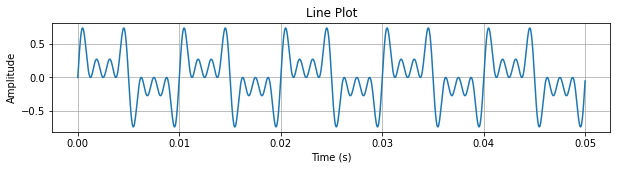

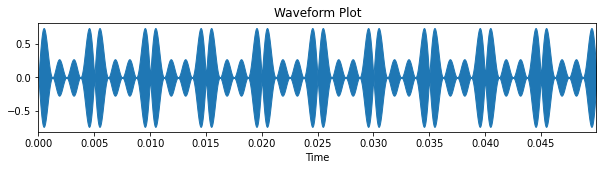

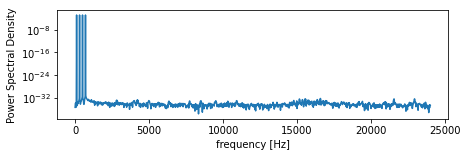

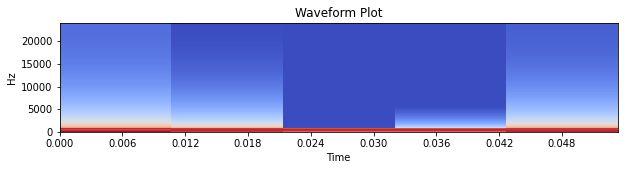

In [3]:
sr=48000

#creating a test signal with multiple frequency components
s = myAddSineSynth([100,300,500,700],50,amps=[0.25,0.25,0.25,0.25],sr=sr)

#using audio files
#s, sr = librosa.load('./files/samples/kick_00.wav', sr)
#s, sr = librosa.load('./files/samples/cymbal16.wav', sr)


#displaying in time domain
myPlotLineTime(s,sr,'Line Plot')
myWaveform(s,sr,'Waveform Plot')

def myPlotLineTime(signal,sr,title):
    time = np.arange(0,signal.size/sr,1/sr)
    time = time[0:signal.size]
    plt.figure(figsize=(10, 2))
    plt.plot(time,signal)
    plt.grid(True)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

#displaying in frequency domain
mySpectrum(s,sr,'Waveform Plot')

#displaying time-frequency domain
mySpectrogram(s,sr,'Waveform Plot')

## 2. Aliasing

If frequency components above half sampling frequency (also called **Nyquist frequency** or **folding frequency**) enters a digital system (from the ADC) or are generated internally (digital signal synthesis) these will show in the range [0 Hz, sr/2 Hz] (also co as "alias" of other frequency components. Once we have an alias, it is no longer to distinguish it with other components in the band [0 Hz, sr/2 Hz].

This effect is calles [aliasing](https://en.wikipedia.org/wiki/Aliasing) and it happens in all digital/discrete representation of analog signals (audio, images, etc).

![aliasing gif](https://upload.wikimedia.org/wikipedia/commons/8/83/FFT_aliasing_600.gif)

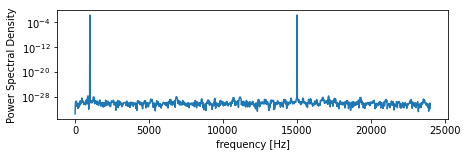

In [4]:
sr=48000

#creating a test signal with multiple frequency components
s = myAddSineSynth([1000,33000],50,sr=sr)

#displaying in frequency domain
mySpectrum(s,sr,'Waveform Plot')

In ADC there is an important analog filter before the sampler and quantizer called Anti Aliasing Filter (as important as the Reconstruction filter of the DAC). Both are analog low pass filters. You can read more about it in [this chapter](https://www.dspguide.com/ch3.htm)

Interactive demo on [Max/MSP](https://cycling74.com/) file AliasingEmulation.maxpat (in 'files' folder).

![ADCandDAC](https://www.dspguide.com/graphics/F_3_7.gif)




## 3. Frequency Domanin Analysis

When we doing frequency analysis, we convert the signal from time to frequency domain via DFT (Discrete Fourier Trannsform). The result of the DFT is used to compute analytical results (e.g. spectral features, or visualizations). In this example we compute and visualize the Spectrum, which is the magnitude of the DFT result.

(2400,) (1201,) (1201,)


Text(0, 0.5, 'Power Spectral Density')

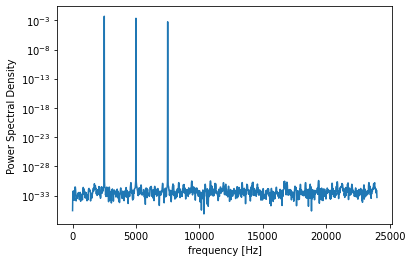

In [5]:
### sr=48000

#creating a test signal with multiple frequency components
s = myAddSineSynth([2500,5000,7500],50,amps=[0.45,0.3,0.15],sr=sr)

#in scipy signal there is already the function periodogram() to compute the spectrum used in mySpectrum()
#the function returns the power  spectral density and the axis with frequencies
#which can be easily plotted on a linear or logarithmic plot

freq, psd = signal.periodogram(s, sr)

#note the dimensions of these numpy arrays
print(s.shape,freq.shape,psd.shape)

#note the resolution (step in frequency between consective values) of the of the spectrogram
#against the lenght of the input signal (zoom into the plot), eventually change the plot to stems

#%matplotlib notebook

plt.semilogy(freq, psd) # log power - similar to dB plot
#plt.plot(f, psd) # linear power 
plt.xlabel('frequency [Hz]')
plt.ylabel('Power Spectral Density')


(2400,) (2400,)
[ 0.          0.45199663  0.70230232 ... -0.68058873 -0.70230232
 -0.45199663]
[-5.70364531e-13-0.00000000e+00j -1.45599458e-13-4.35134133e-13j
 -1.52648521e-13+1.26690743e-13j ... -4.54383269e-13+3.90212963e-13j
 -1.52648521e-13-1.26690743e-13j -1.45599458e-13+4.35134133e-13j]


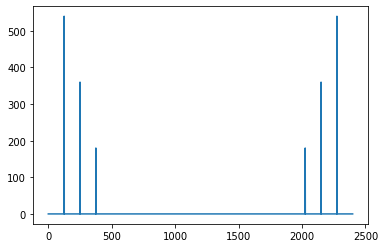

In [6]:
sr=48000

#creating a test signal with multiple frequency components
s = myAddSineSynth([2500,5000,7500],50,amps=[0.45,0.3,0.15],sr=sr)

#the following code produces a similar ourput then the periodogram
S = scipy.fft.fft(s)
# S = np.fft.fft(s) #we have the same collection of functionf in Numpy

# note the size and contents (data type), the DFT produces complex  numbers
print(s.shape,S.shape)

print(s)
print(S)

%matplotlib inline

# given a complex number we  can compute its phase and magnitude. The magnitude represents the spectrum
spectrum = np.abs(S)
plt.plot(spectrum)

(2400,) (1201,)


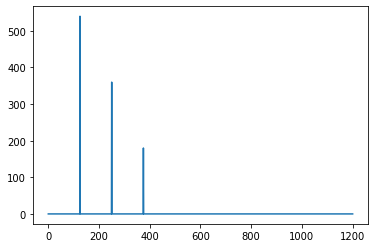

In [7]:
# The DFT returns positive frequencies followed by negative frequencies in flipped order
# for real signals (audio is real) the positive and negative frequencies are symmetric
# therefore we consider/display/analyze only the positive half (i.e first half + 1, which id the DC - 0 HZ)

psd = np.abs(S[0:math.floor(len(S)/2)+1])

print(s.shape,psd.shape)

%matplotlib inline

#linear vertical axis
plt.plot(psd)

#log vertical axis
#plt.semilogy(psd)

(2400,) (1201,)


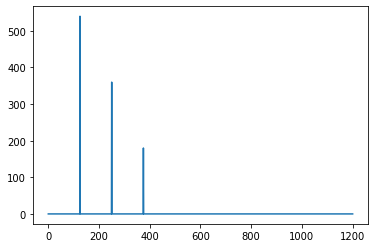

In [8]:
#alternatively we can use the real fft function, which just returns only positive frequencies)
S = scipy.fft.rfft(s)

psd = np.abs(S)

print(s.shape,psd.shape)

%matplotlib inline

#linear vertical axis
plt.plot(psd)

#log vertical axis
#plt.semilogy(psd)

Text(0, 0.5, 'Power Spectral Density')

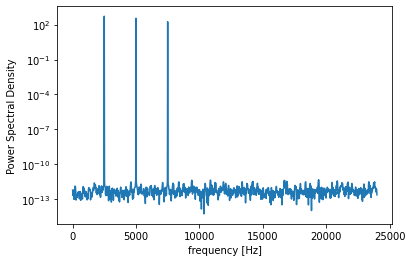

In [9]:
# Now we need to "build" the values for the frequency axis
# Which values should go from O Hz to SR/2 HZ
# we use np.linespace rather than np.arange as it automatically finds the right step (we pass the desired size)

freq = np.linspace(0, sr/2, len(psd))

plt.semilogy(freq, psd) # log power - similar to dB plot
#plt.plot(f, psd) # linear power 
plt.xlabel('frequency [Hz]')
plt.ylabel('Power Spectral Density')

(2400,) (1201,) (1201,)


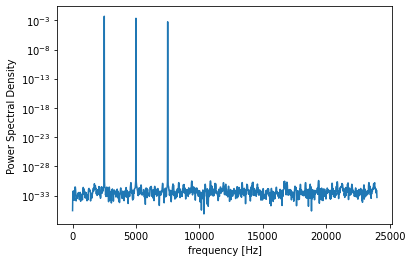

In [10]:
freq, psd = signal.periodogram(s, sr)

#note the dimensions of these numpy arrays
print(s.shape,freq.shape,psd.shape)

plt.semilogy(freq, psd) # log power - similar to dB plot
#plt.plot(f, psd) # linear power 
plt.xlabel('frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.show()

## 4. Frequency Domanin Processinng

When we doing frequency processing, we transform the signal in the frequency domain, where we perform some proccessing (i.e. apply a filter, remember that a filter is not only an "equalizer" but any kind of audio processing), and then we convert the audio back in the time domain, where we can reproduce and or/store the resultign audio.

(2400,) (2400,)
[ 0.          0.03917517  0.0777853  ... -0.11528205 -0.0777853
 -0.03917517]
[-3.36580653e-31  3.91751729e-02  7.77853011e-02 ... -1.15282046e-01
 -7.77853011e-02 -3.91751729e-02]


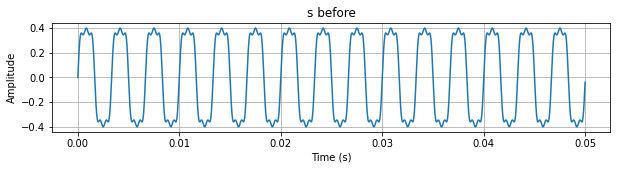

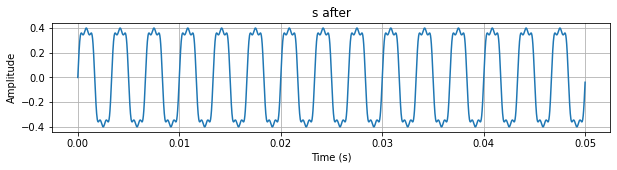

In [11]:
# here we convert the audio signal back and forth from time (real numbers) 
# to frequancy domain (complex numbers) and then from frequenncy and to time again.

sr=48000

#creating a test signal with multiple frequency components
s_before = myAddSineSynth([300,900,1500],50,amps=[0.45,0.10,0.05],sr=sr)

# to frequency domain (do not use the real fft (rfft) when  doing processing!!!)
S = scipy.fft.fft(s_before)

# back to time domain (keeping only the real part)
s_after = np.real(scipy.fft.ifft(S))

# note the size and contents (minor differences exists due to finite numerical precision)
print(s_before.shape,s_after.shape)
print(s_before)
print(s_after)

%matplotlib inline

myPlotLineTime(s_before,sr,'s before')
myPlotLineTime(s_after,sr,'s after')

# increase the signal dutation for a better playback
sd.play(s_before,sr)
sd.wait()
sd.play(s_after,sr)
sd.wait()



(2400,) (55,) (2400,)
(2400,)


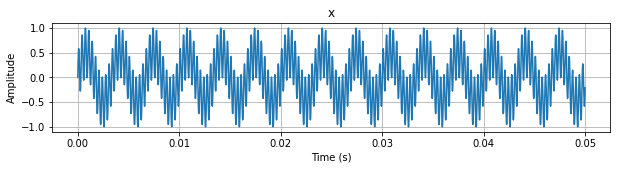

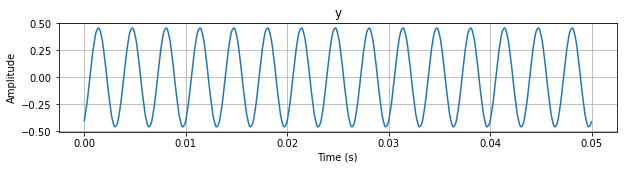

In [12]:
# an important principle is that the convolution in the time domain
# is equivalent to the product (element by element) in the frequency domain (complex number product)
# therefore we can apply FIR filters by muptiplying 
# the DFT of the signal with the DFT of the impulse response

# a condition to perform the product, is that both arrays (output of DFT)
# present equal lenght (in time domain, convolution does not have this requirement)
# in order to achieve this wehave to "zero pad" the shorter between the two
# to match the lenght of the longer


sr=48000

#creating a test signal with multiple frequency components
x = myAddSineSynth([300,3000],50,amps=[0.5,0.5],sr=sr)

#designing low pass FIR to remove 3000 Hz
numtaps = 55
fc = 0.01 
h = signal.firwin(numtaps, fc, pass_zero=True)

# zero padding h to match x (at times it may be necessary to do the opposite)
h_padded = np.pad(h,[0,x.size-h.size])

print(x.shape,h.shape,h_padded.shape)

# to frequency domain (do not use the real fft (rfft) when doing processing!!!)
X = scipy.fft.fft(x)
H = scipy.fft.fft(h_padded)

# applying filter (product)
Y = X*H

# back to time domain
y = np.real(scipy.fft.ifft(Y))

print(y.shape)

%matplotlib inline

myPlotLineTime(x,sr,'x')
myPlotLineTime(y,sr,'y')

sd.play(x,sr)
sd.wait()
sd.play(y,sr)
sd.wait()

(11085,) (98932,)
(11085,) (98932,) (98932,)
(98932,)


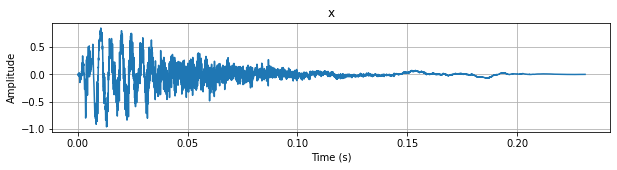

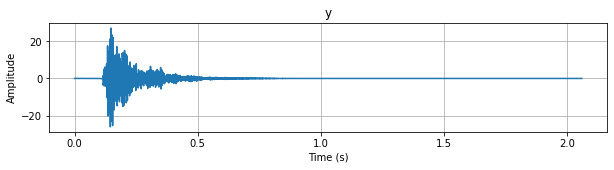

In [13]:
# repeating the same, but this time we use an drum sample and a room impulse response

sr=48000

x, sr = librosa.load('./files/samples/snare_00.wav', sr)
h, sr = librosa.load('./files/IR_small_church.wav', sr)

print(x.shape,h.shape)

# zero padding x to match h (opposite than before)
x_padded = np.pad(x,[0,h.size-x.size])

print(x.shape,h.shape,x_padded.shape)

# to frequency domain (do not use the real fft (rfft) when doing processing!!!)
X = scipy.fft.fft(x_padded)
H = scipy.fft.fft(h)

# applying filter (product)
Y = X*H

# back to time domain
y = np.real(scipy.fft.ifft(Y))

print(y.shape)

%matplotlib inline

myPlotLineTime(x,sr,'x')
myPlotLineTime(y,sr,'y')

sd.play(x,sr)
sd.wait()
sd.play(y/np.max(y),sr)  # normalizing before playback, output of convolution may exceed +/- 1
sd.wait()

In [14]:
### summary of methods to apply a FIR (they all produce equivalent output)

sr=48000

x, sr = librosa.load('./files/samples/snare_00.wav', sr)
h, sr = librosa.load('./files/IR_small_church.wav', sr)

# numpy convolution
start_time = time.time()
y1 = np.convolve(x,h) ############################################
exec_time = time.time() - start_time
print('y1 exec time',exec_time)


# scipy signal convolution
start_time = time.time()
y2 = signal.convolve(x,h) ############################################
exec_time = time.time() - start_time
print('y2 exec time',exec_time)


# scipy signal filter
start_time = time.time()
y3 = signal.lfilter(h,1,x) ############################################
exec_time = time.time() - start_time
print('y3 exec time',exec_time)


# scipy freq domain convolution
start_time = time.time()
y4 = scipy.signal.fftconvolve(x,h) ############################################
exec_time = time.time() - start_time
print('y4 exec time',exec_time)


# performing convolutionn manually in time domain
def myConvTime(x,h):
    
    # this works only if x is longer or equal than h
    # if h is longer, we swap them (conv x*h is equal to conv h*x)
    if h.size > x.size:
        temp = x
        x = h
        h = temp
    
    y = np.zeros([x.size+h.size-1])
    
    for n in range(y.size):
        kmin = n - (h.size - 1) if (n >= h.size - 1) else 0
        kmax = n if (n < x.size - 1) else x.size - 1

        for k in range(kmin,kmax+1):
            y[n] += x[k] * x[n - k]
            
            
    return y
      
#start_time = time.time()
#y5 = myConvTime(x,h) #THIS WILL TAKE A LOT OF TIME###########################################
#exec_time = time.time() - start_time
#print('y5 exec time',exec_time)
      
    
# performing convolutionn manually in freq domain
def myConvFreq(x,h):
    if x.size > h.size:
        h = np.pad(h,[0,x.size-h.size])
    elif h.size > x.size:
        x = np.pad(x,[0,h.size-x.size])
    
    X = scipy.fft.fft(x)
    H = scipy.fft.fft(h)
    Y = X*H
    y = np.real(scipy.fft.ifft(Y))
    
    return y

start_time = time.time()
y6 = myConvFreq(x,h) ############################################
exec_time = time.time() - start_time
print('y6 exec time',exec_time)

y1 exec time 0.09848403930664062
y2 exec time 0.005887031555175781
y3 exec time 0.2609741687774658
y4 exec time 0.004049062728881836
y6 exec time 0.030081987380981445


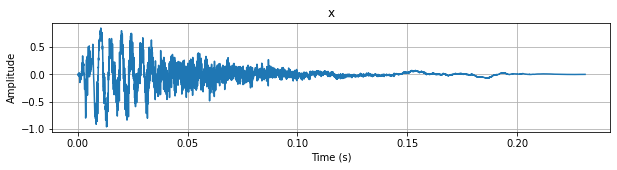

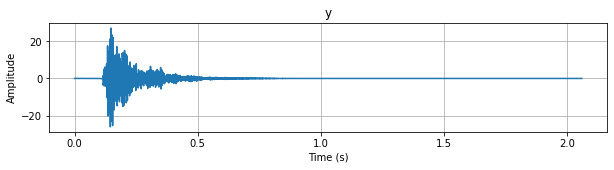

In [15]:
y = y6# select one among y1 to y6

myPlotLineTime(x,sr,'x')
myPlotLineTime(y,sr,'y')

sd.play(x,sr)
sd.wait()
sd.play(y/np.max(y),sr)  # normalizing before playback, output of convolution may exceed +/- 1
sd.wait()